# Bible NLP

In this notebook, we will apply some natural language processing techniques to some chocen texts from the Gospels.

The goal is to verify the behavior of these techniques with these particular texts, in particular if they can capture information without changing the meaning of the text.

The verses are taken from the American Standard Version (ASV) of the Bible, available as csv file from this Kaggle [dataset](https://www.kaggle.com/datasets/oswinrh/bible/code).

In [1]:
import pandas as pd

def load_data():
    key2name = pd.read_csv('data/key_english.csv')
    key2name.drop(columns=['t', 'g'], inplace=True)

    bible_df = pd.read_csv('data/t_asv.csv')
    bible_df = bible_df[(bible_df['b'] >= 40) & (
        bible_df['b'] <= 43)]  # Matthew, Mark, Luke, John
    bible_df = bible_df.merge(key2name, on='b')

    # Given a reference return the text
    def get_verse_text(verse: str):
        reference = verse.split('-')
        book, start = reference[0].split(' ')
        start_chapter, start_verse = start.split(',')
        if len(reference) == 2:
            end_chapter, end_verse = reference[1].split(',')
        else:
            end_chapter, end_verse = start_chapter, start_verse

        start = int(
            f"{key2name[key2name['n'] == book]['b'].values[0]:02d}{int(start_chapter):03d}{int(start_verse):03d}")
        end = int(
            f"{key2name[key2name['n'] == book]['b'].values[0]:02d}{int(end_chapter):03d}{int(end_verse):03d}")
        text = bible_df[(bible_df['id'] >= start) & (
            bible_df['id'] <= end)]['t'].str.cat(sep=' ')
        return text

    # List of verses to analyze and their category:
    # 0 - events
    # 1 - parables
    # 2 - miracles
    # 3 - teachings
    verses = {
        'Matthew 1,18-1,25': 0,     # Nascità di Gesù secondo Matteo
        'Matthew 3,13-3,17': 0,     # Battesimo di Gesù secondo Matteo
        'Matthew 4,1-4,11': 0,      # Tentazioni di Gesù secondo Matteo
        'Matthew 5,1-7,29': 3,      # Discorso della montagna
        'Matthew 9,18-9,26': 2,     # Risurrezione della figlia di Giairo e guarigione della donna malata
        'Matthew 13,1-13,23': 1,    # Parabola del seminatore
        'Matthew 13,44-13,46': 1,   # Parabola del tesoro e della perla
        'Matthew 17,1-17,8': 0,     # Trasfigurazione di Gesù
        'Matthew 18,1-18,5': 3,     # I più piccoli nel regno dei cieli
        'Matthew 28,1-28,8': 0,     # Risurrezione di Gesù secondo Matteo
        'Mark 1,9-1,11': 0,         # Battesimo di Gesù secondo Marco
        'Mark 4,1-4,20': 1,         # Parabola del seminatore
        'Mark 4,35-4,41': 2,        # Tempesta sedata
        'Mark 8,34-8,38': 3,        # Rinnegarsi per seguire Gesù
        'Mark 9,2-9,8': 0,          # Trasfigurazione di Gesù
        'Mark 10,13-10,16': 3,      # I più piccoli nel regno dei cieli
        'Mark 16,1-16,8': 0,        # Risurrezione di Gesù secondo Marco
        'Luke 1,26-1,38': 0,        # Annunciazione a Maria
        'Luke 2,1-2,20': 0,         # Nascita di Gesù secondo Luca
        'Luke 3,21-3,22': 0,        # Battesimo di Gesù secondo Luca
        'Luke 4,1-4,13': 0,         # Tentazioni di Gesù secondo Luca
        'Luke 6,20-6,49': 3,        # Discorso della montagna secondo Luca
        'Luke 7,1-7,10': 2,         # Guarigione del servo del centurione
        'Luke 8,4-8,15': 1,         # Parabola del seminatore
        'Luke 9,18-9,27': 0,        # Trasfigurazione di Gesù
        'Luke 9,46-9,48': 3,        # I più piccoli nel regno dei cieli
        'Luke 15,11-15,32': 2,      # Parabola del figliol prodigo
        'Luke 24,1-24,12': 0,       # Risurrezione di Gesù secondo Luca
        'John 1,1-1,18': 3,         # Prologo del Vangelo secondo Giovanni
        'John 1,29-1,34': 0,        # Battesimo di Gesù secondo Giovanni
        'John 2,1-2,11': 2,         # Nozze di Cana
        'John 3,1-3,21': 3,         # Incontro con Nicodemo
        'John 4,1-4,42': 3,         # Incontro con la Samaritana
        'John 11,1-11,44': 2,       # Risurrezione di Lazzaro
        'John 13,1-17,26': 3,       # Ultima cena
        'John 20,1-20,18': 0        # Risurrezione di Gesù secondo Giovanni
    }

    # Get the text of the verses
    verses_text = [get_verse_text(verse) for verse in verses]

    # Save the verses text in a dataframe
    verses_df = pd.DataFrame({'verse': verses.keys(), 'text': verses_text, 'category': verses.values()})
    return verses_df

# Load the data
verses_df = load_data()
verses_df

,verse,text,category
0,"Matthew 1,18-1,25",Now the birth of Jesus Christ was on this wise...,0
1,"Matthew 3,13-3,17",Then cometh Jesus from Galilee to the Jordan u...,0
2,"Matthew 4,1-4,11",Then was Jesus led up of the Spirit into the w...,0
3,"Matthew 5,1-7,29","And seeing the multitudes, he went up into the...",3
4,"Matthew 9,18-9,26","While he spake these things unto them, behold,...",2
5,"Matthew 13,1-13,23","On that day went Jesus out of the house, and s...",1
6,"Matthew 13,44-13,46",The kingdom of heaven is like unto a treasure ...,1
7,"Matthew 17,1-17,8",And after six days Jesus taketh with him Peter...,0
8,"Matthew 18,1-18,5","In that hour came the disciples unto Jesus, sa...",3
9,"Matthew 28,1-28,8","Now late on the sabbath day, as it began to da...",0


## Classification

We will start by classifying the texts into four categories:

0. Events from the life of Jesus
1. Parables
2. Miracles
3. Teachings or discourses of Jesus

We have already classified the texts manually, the goal is to see and compare classification made by some different models (Decision Tree, Random Forest and Naive Bayes) and the real classification.

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
from sklearn.model_selection import cross_val_score

def classification(clf, verses_df, threshold):
    def preprocess(text, n):
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        ngrams_set = set()
        for i in range(1, n+1):
            processed_text = ngrams(tokens, i)
            ngrams_set.update([' '.join(gram) for gram in processed_text])
        return ngrams_set

    def build_token_dictionary(df: pd.DataFrame, column: str):
        tokens_dict = defaultdict(set)
        for idx, record in enumerate(df[column]):
            for token in record:
                tokens_dict[token].add(idx)
        return tokens_dict
    
    def entropy(df: pd.DataFrame):
        labels = set(df['category'].values)
        entropy = 0
        for label in labels:
            p = len(df[df['category'] == label]) / len(df)
            entropy -= p * np.log(p)
        return entropy
    
    def information_gain(df: pd.DataFrame, H, token: str):
        token_df = df[df['tokens'].apply(lambda x: token in x)]
        token_count = len(token_df)
        token_entropy = entropy(token_df)
        return H - token_count / len(df) * token_entropy
    
    def to_numeric(df: pd.DataFrame, best_features: pd.DataFrame, threshold):
        index = {}
        for idx, token in enumerate(best_features['token']):
            index[token] = idx
        numeric_df = np.zeros((len(df), threshold))
        target = np.zeros(len(df))

        for idx, record in df.iterrows():
            for token in record['tokens']:
                numeric_df[idx, index[token]] = 1
            target[idx] = record['category']
        return numeric_df, target
    
    verses_df['tokens'] = verses_df['text'].apply(preprocess, n=3)
    tokens_dict = build_token_dictionary(verses_df, 'tokens')
    df_tokens = pd.DataFrame(zip(tokens_dict.keys(), tokens_dict.values()), columns=['token', 'verses'])

    count = []
    for t in df_tokens['verses']:
        count.append(len(t))
    df_tokens['count'] = count
    df_tokens = df_tokens[df_tokens['count'] > 1]

    H = entropy(verses_df)
    df_tokens['information_gain'] = df_tokens['token'].apply(lambda x: information_gain(verses_df, H, x))
    df_tokens.sort_values(by='information_gain', ascending=False, inplace=True)
    df_tokens = df_tokens[:threshold]

    new_texts = []
    for tokens in verses_df['tokens']:
        intesect = set(tokens).intersection(set(df_tokens['token'].values))
        new_texts.append(intesect)
    verses_df['tokens'] = new_texts
    numeric_df, target = to_numeric(verses_df, df_tokens, threshold)
    
    # The classifier is trained with a 4-fold cross validation
    scores = cross_val_score(clf, numeric_df, target, cv=4)
    return scores.mean(), scores.std()

We will compare mean and standard deviations of the cross-validation scores of the three models varying the number of features used.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

mean = []
std = []
decision_tree = DecisionTreeClassifier(random_state=1234567)
random_forest = RandomForestClassifier(random_state=1234567)
naive_bayes = MultinomialNB()

x_axis = range(100, 400, 50)

for i in x_axis:
    mean_dt, std_dt = classification(decision_tree, verses_df, i)
    mean_rf, std_rf = classification(random_forest, verses_df, i)
    mean_nb, std_nb = classification(naive_bayes, verses_df, i)
    mean.append((mean_dt, mean_rf, mean_nb))
    std.append((std_dt, std_rf, std_nb))

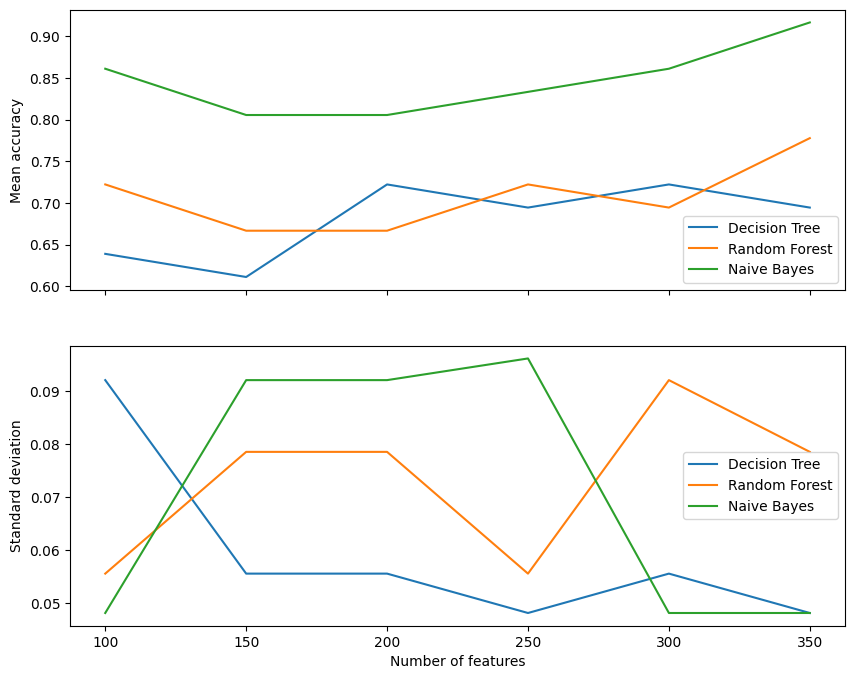

In [16]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(x_axis, mean, label=('Decision Tree', 'Random Forest', 'Naive Bayes'))
ax1.set(ylabel='Mean accuracy')
ax1.legend()

ax2.plot(x_axis, std, label=('Decision Tree', 'Random Forest', 'Naive Bayes'))
ax2.set(xlabel='Number of features', ylabel='Standard deviation')
ax2.legend()
plt.show()

From the graphs below, we can see that the best model is the Naive Bayes in all cases, while Decision Tree and Random Forest have similar performances.

The standard deviation is always very low, so the models are stable.

The main problem of this comparison is that the performance of Decision Tree and Random Forest depends on the seed used, so the results are not always the same.

## Clustering

In this section we will try to cluster the texts. The goal is to see if the clusters are similar to the categories defined above and if parallel texts are clustered together.